# GPVAE model

In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import gpytorch
import matplotlib.pyplot as plt
import pandas as pd
import copy
from torch.utils.data import Dataset, DataLoader,random_split, Subset, ConcatDataset
from tqdm import tqdm

sys.path.append(os.path.abspath('..'))
from GP import *
from Models.GPVAE import GPVAE

import warnings
# Suppress only the specific GPInputWarning coming from the exact_gp.py file
warnings.filterwarnings(
    "ignore", 
    message="The input matches the stored training data. Did you forget to call model.train()?", 
    module=".*exact_gp"
)

In [2]:
# Import RICO data 
file_path = '../Data/RICO4_Dataset_processed.hdf'
df = pd.read_hdf(file_path)
"""
for i in df['interval'].unique():
    id = df['interval'] == i
    plt.plot(df[id]['time_within_interval'].to_numpy(), df[id]['B.RTD1'].to_numpy())
plt.xlabel('time (min)')
plt.ylabel('Temperature (°C)')
plt.show()
"""
df_c = df[df['temp_change_class'] == 'c']

def select_points(group):
    return group.iloc[::10]  # Select every 10th row
df_c = df_c.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)

class RICO4Dataset(Dataset):
    def __init__(self, df_c):
        self.df_c = df_c
        self.unique_intervals = df_c['interval'].unique()

    def __len__(self):
        return len(self.unique_intervals)

    def __getitem__(self, idx):
        batch = self.unique_intervals[idx]
        id = self.df_c['interval'] == batch
        temp = torch.tensor(self.df_c[id]['B.RTD1'].to_numpy(), dtype=torch.float32)
        ti = torch.tensor(self.df_c[id]['time_within_interval'].to_numpy()/240, dtype=torch.float32)
        x_batch = torch.cat((temp.unsqueeze(1), ti.unsqueeze(1)), axis=1)
        return x_batch
dataset = RICO4Dataset(df_c)
# Define split ratios
train_ratio = 0.7
test_ratio = 1-train_ratio

# Calculate split sizes
total_size = len(dataset)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

seed = 0
generator = torch.Generator().manual_seed(seed)

# Split the dataset
train_subset, test_subset = random_split(
    dataset,
    [train_size, test_size],
    generator=generator
)
train_loader = DataLoader(train_subset, batch_size=1, shuffle=False)
val_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_7406/3227586179.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_c = df_c.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)


In [3]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
torch.manual_seed(1)
model = GPVAE(GP_inf = GP_inference(kernel), 
              activation_decoder=nn.ReLU(),
              hidden_layers_encoder=[10])

In [4]:
gp_params = []
base_params = []

for name, param in model.named_parameters():
    if 'GP' in name:
        gp_params.append(param)  # Gaussian Process parameters
    else:
        base_params.append(param)  # Other parameters

base_lr = 0.001  # Learning rate for base parameters
gp_lr = 0.0001  # Learning rate for GP parameters
# Create separate parameter groups in the optimizer
opt = torch.optim.Adam([
    {'params': base_params, 'lr': base_lr},
    {'params': gp_params, 'lr': gp_lr}
])
opt.zero_grad()


In [5]:
t_uni=torch.tensor(
    [  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101., 111.,
        121., 131., 141., 151., 161., 171., 181., 191., 201., 211., 221., 231.]
)

Training Progress:   0%|          | 0/270 [00:00<?, ?it/s]

Training Progress:   4%|▍         | 11/270 [00:00<00:22, 11.28it/s]

Epoch 13:
  Training - Loss = 117.3644, KL = 0.4890, MSE = 117.8534, CE = 3.1983
  Validation - Loss = 120.5316, KL = 0.4886, MSE = 121.0202, CE = 3.1921
  Mean q_mu = 1.7687, Mean q_var = 32.8757


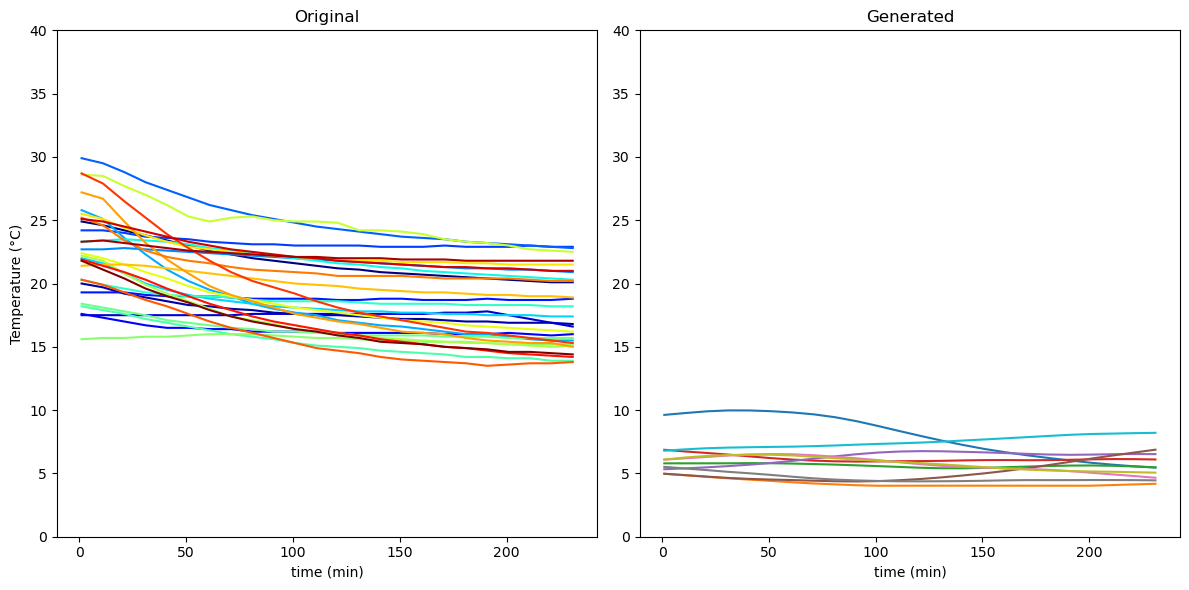

Training Progress:   9%|▉         | 24/270 [00:02<00:24, 10.03it/s]

Epoch 26:
  Training - Loss = 56.5969, KL = 0.4613, MSE = 57.0582, CE = 2.7037
  Validation - Loss = 58.6873, KL = 0.4610, MSE = 59.1483, CE = 2.6757
  Mean q_mu = 1.7964, Mean q_var = 11.9647


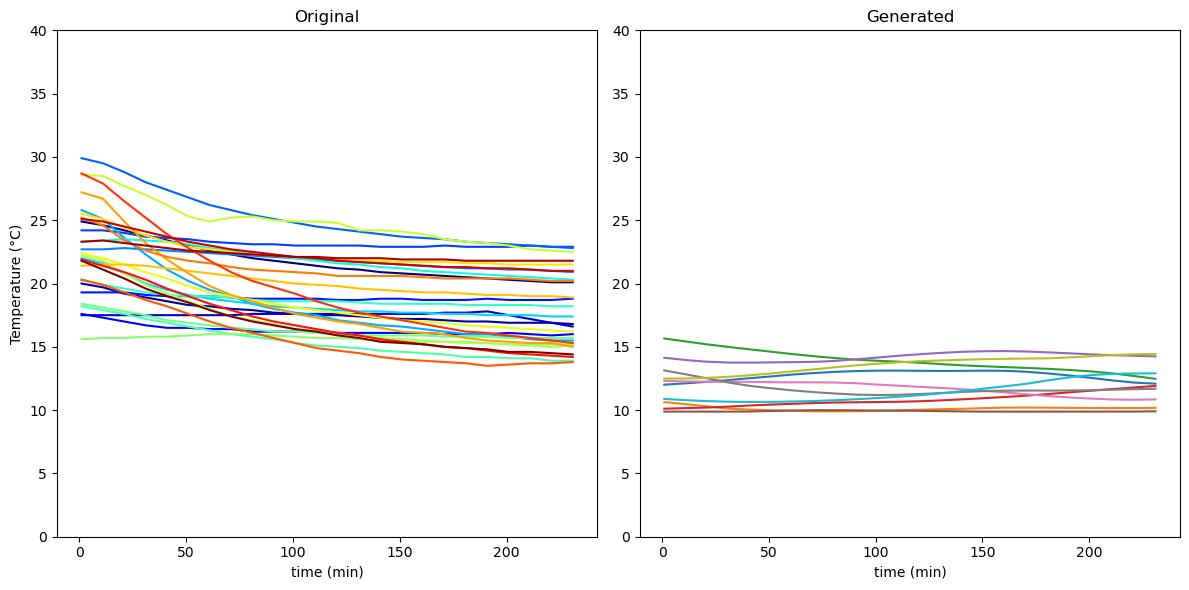

Training Progress:  14%|█▎        | 37/270 [00:03<00:22, 10.45it/s]

Epoch 39:
  Training - Loss = 11.2366, KL = 0.4372, MSE = 11.6738, CE = 1.5519
  Validation - Loss = 11.5791, KL = 0.4361, MSE = 12.0151, CE = 1.5916
  Mean q_mu = 0.7595, Mean q_var = 1.2100


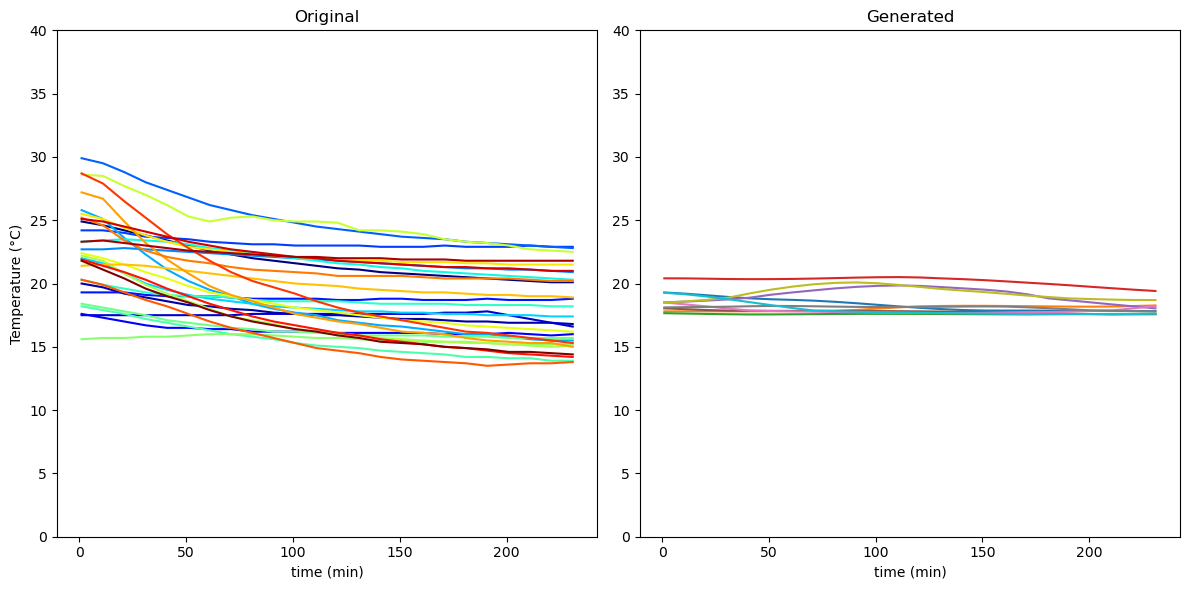

Training Progress:  19%|█▊        | 50/270 [00:05<00:20, 10.86it/s]

Epoch 52:
  Training - Loss = 10.9755, KL = 0.4237, MSE = 11.3991, CE = 1.3201
  Validation - Loss = 8.4646, KL = 0.4205, MSE = 8.8851, CE = 1.3482
  Mean q_mu = 0.6877, Mean q_var = 0.7501


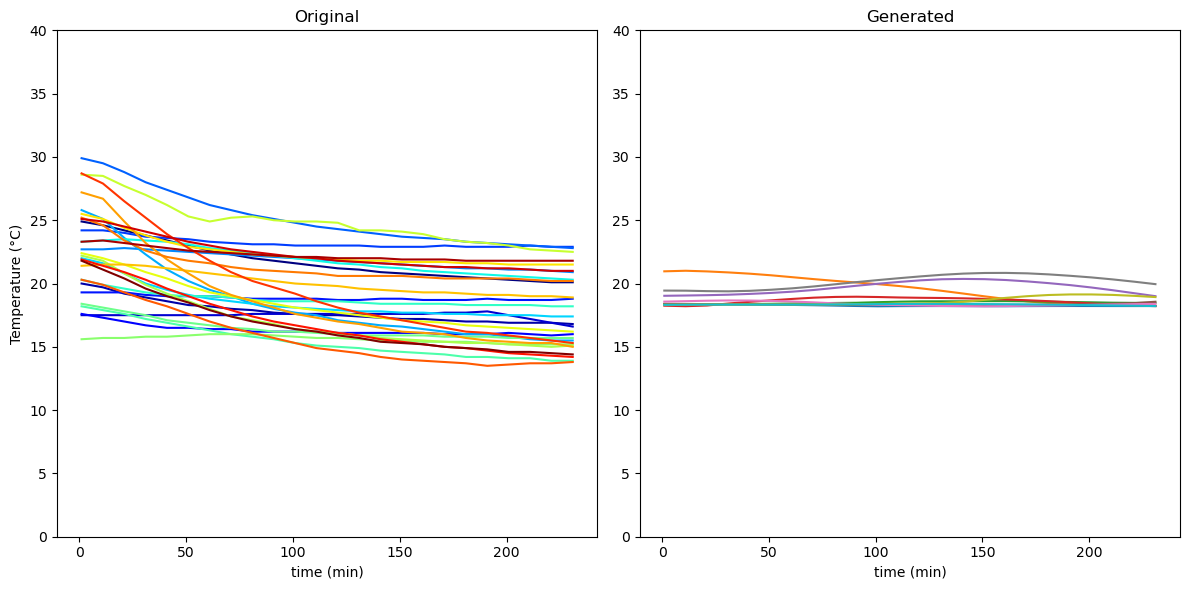

Training Progress:  23%|██▎       | 63/270 [00:06<00:18, 11.00it/s]

Epoch 65:
  Training - Loss = 10.7006, KL = 0.4096, MSE = 11.1103, CE = 1.2428
  Validation - Loss = 8.2914, KL = 0.4025, MSE = 8.6939, CE = 1.2777
  Mean q_mu = 0.8173, Mean q_var = 0.6398


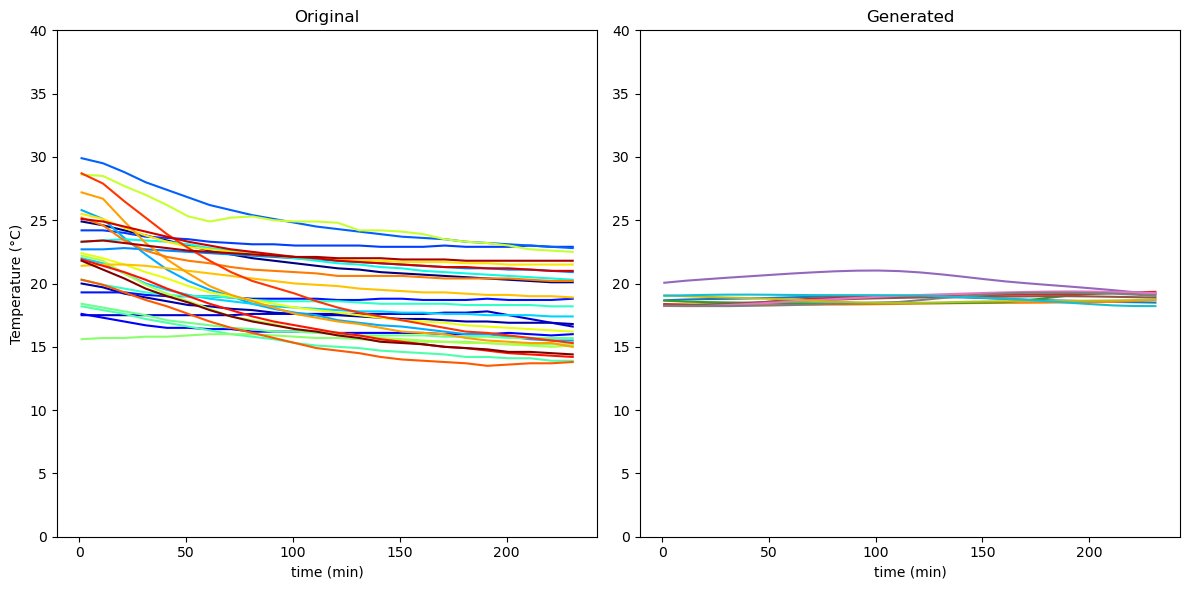

Training Progress:  28%|██▊       | 76/270 [00:07<00:17, 10.91it/s]

Epoch 78:
  Training - Loss = 9.5041, KL = 0.3871, MSE = 9.8912, CE = 1.1875
  Validation - Loss = 7.4129, KL = 0.3785, MSE = 7.7914, CE = 1.2168
  Mean q_mu = 1.0409, Mean q_var = 0.5680


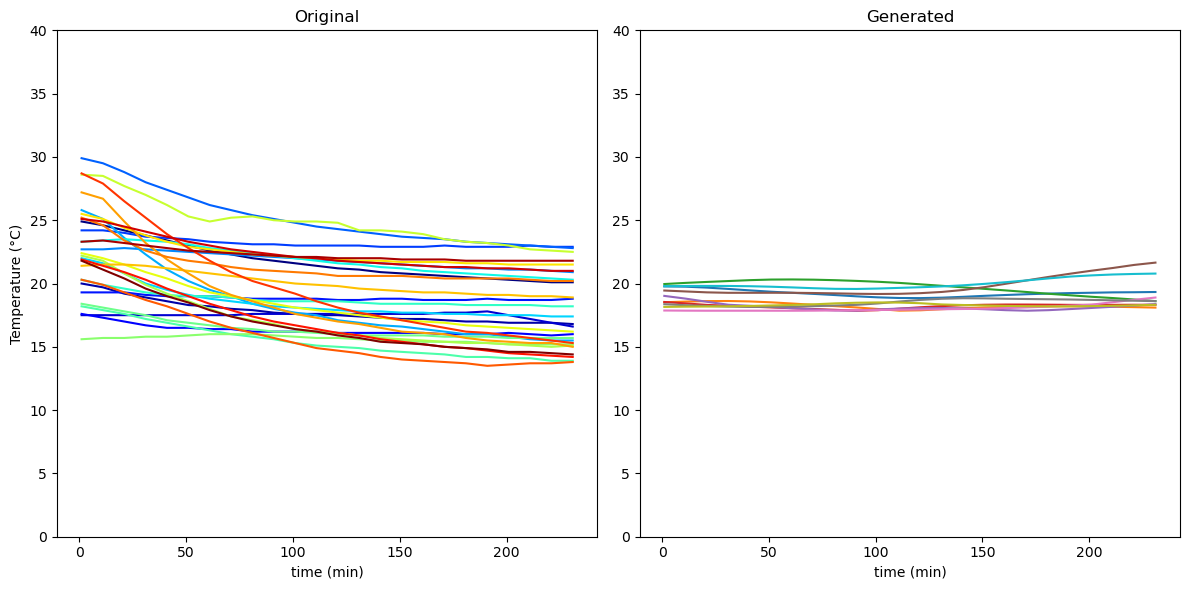

Training Progress:  33%|███▎      | 90/270 [00:09<00:16, 10.94it/s]

Epoch 91:
  Training - Loss = 8.1844, KL = 0.3622, MSE = 8.5467, CE = 1.0250
  Validation - Loss = 6.7856, KL = 0.3428, MSE = 7.1283, CE = 1.0640
  Mean q_mu = 1.1028, Mean q_var = 0.4049


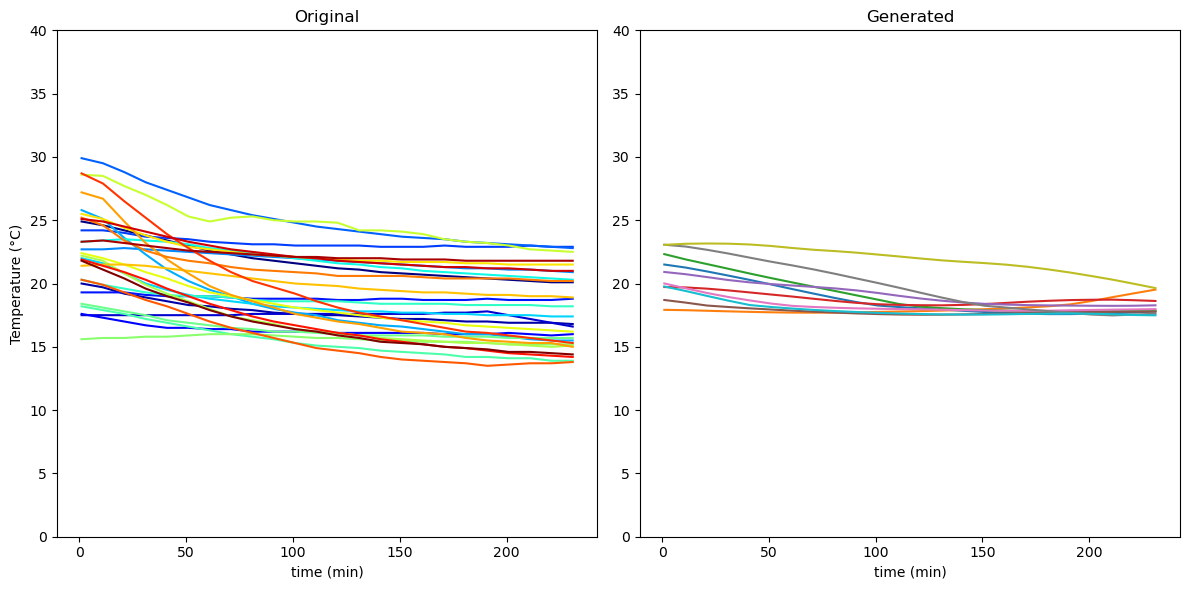

Training Progress:  38%|███▊      | 102/270 [00:10<00:15, 10.89it/s]

Epoch 104:
  Training - Loss = 6.0011, KL = 0.3250, MSE = 6.3262, CE = 0.8085
  Validation - Loss = 4.7267, KL = 0.2964, MSE = 5.0232, CE = 0.8420
  Mean q_mu = 1.1391, Mean q_var = 0.2577


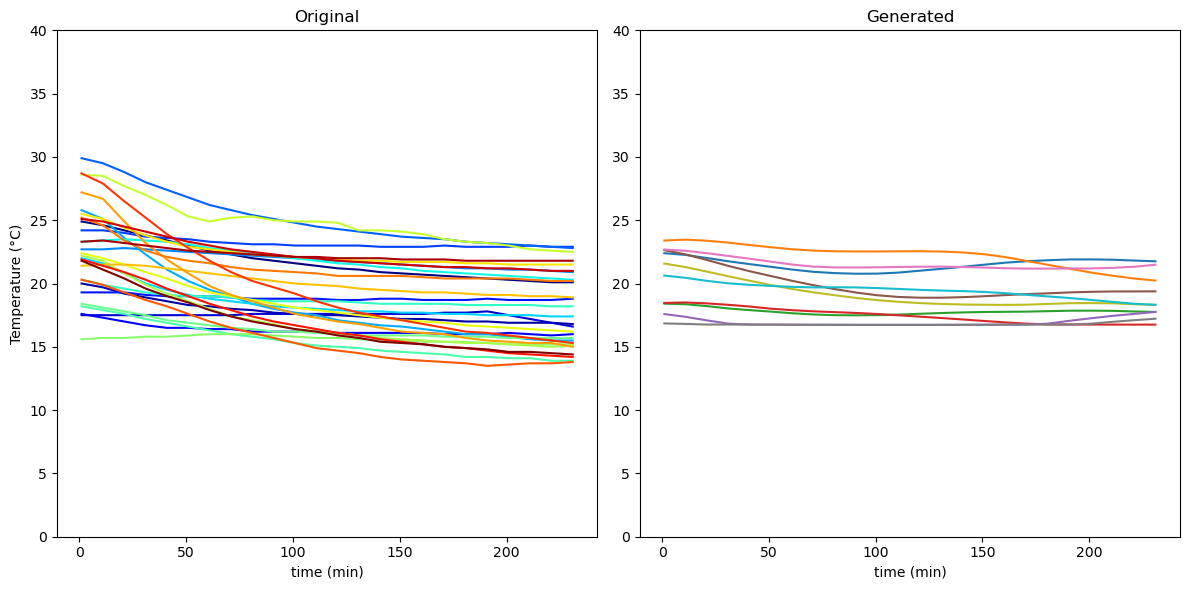

Training Progress:  43%|████▎     | 115/270 [00:11<00:14, 10.75it/s]

Epoch 117:
  Training - Loss = 3.4065, KL = 0.2944, MSE = 3.7009, CE = 0.6117
  Validation - Loss = 2.4763, KL = 0.2574, MSE = 2.7337, CE = 0.6404
  Mean q_mu = 1.0381, Mean q_var = 0.1704


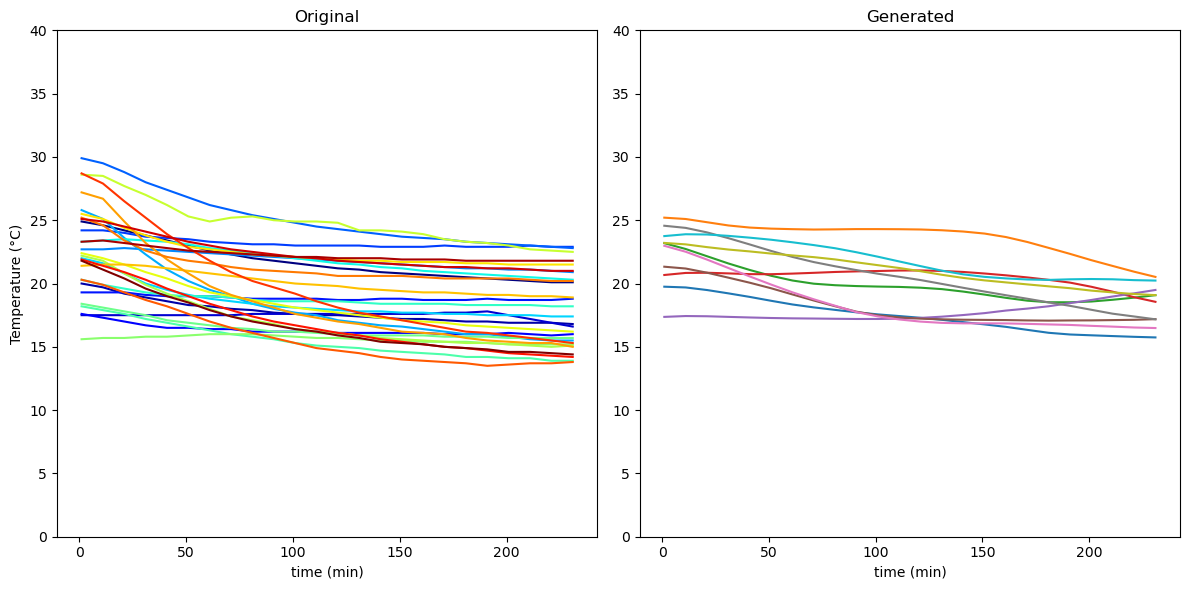

Training Progress:  48%|████▊     | 129/270 [00:12<00:12, 11.07it/s]

Epoch 130:
  Training - Loss = 2.0080, KL = 0.2573, MSE = 2.2654, CE = 0.4165
  Validation - Loss = 2.1682, KL = 0.2139, MSE = 2.3822, CE = 0.4367
  Mean q_mu = 0.9932, Mean q_var = 0.1133


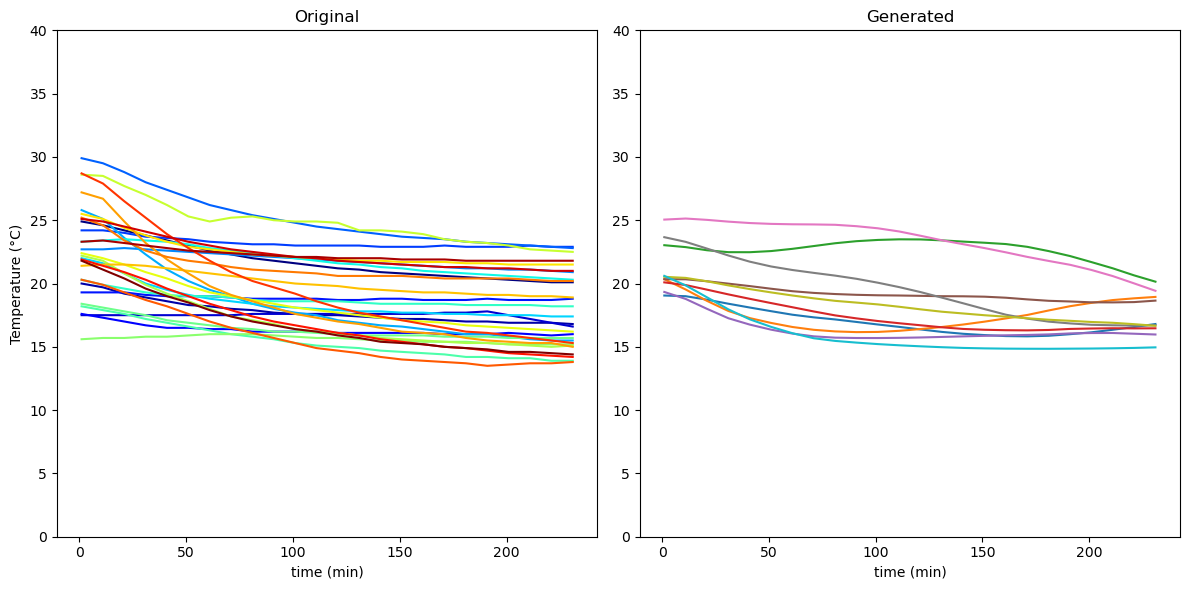

Training Progress:  53%|█████▎    | 142/270 [00:14<00:11, 10.92it/s]

Epoch 143:
  Training - Loss = 1.2353, KL = 0.2241, MSE = 1.4594, CE = 0.2278
  Validation - Loss = 1.2319, KL = 0.1741, MSE = 1.4060, CE = 0.2440
  Mean q_mu = 0.9358, Mean q_var = 0.0766


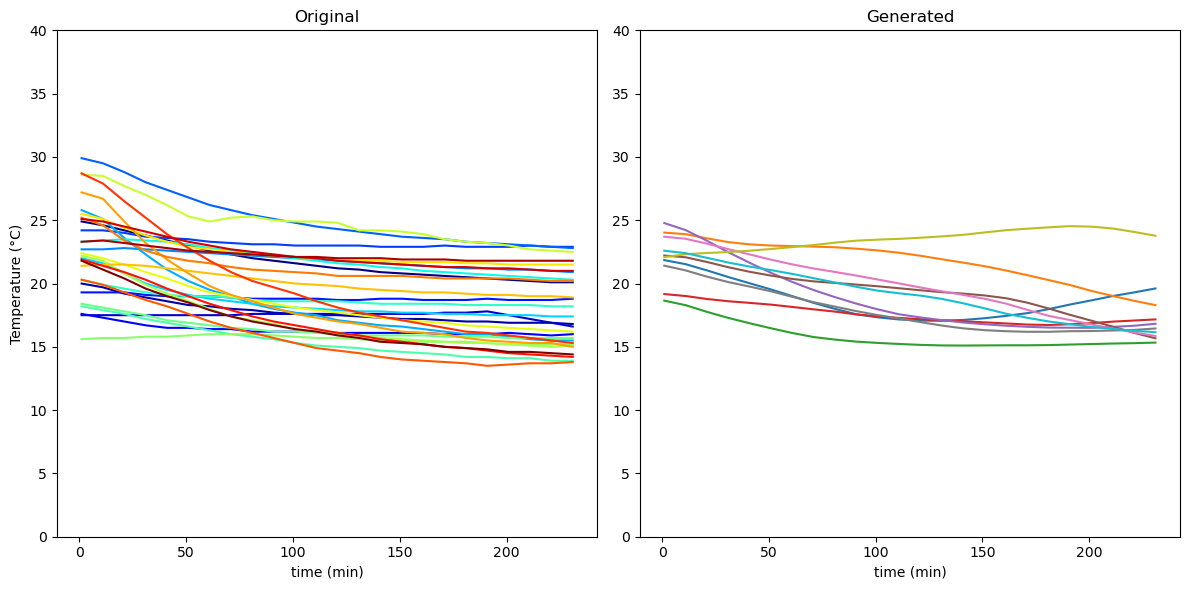

Training Progress:  57%|█████▋    | 154/270 [00:15<00:10, 10.87it/s]

Epoch 156:
  Training - Loss = 0.8218, KL = 0.2008, MSE = 1.0225, CE = 0.0735
  Validation - Loss = 0.8449, KL = 0.1537, MSE = 0.9986, CE = 0.0840
  Mean q_mu = 0.8512, Mean q_var = 0.0557


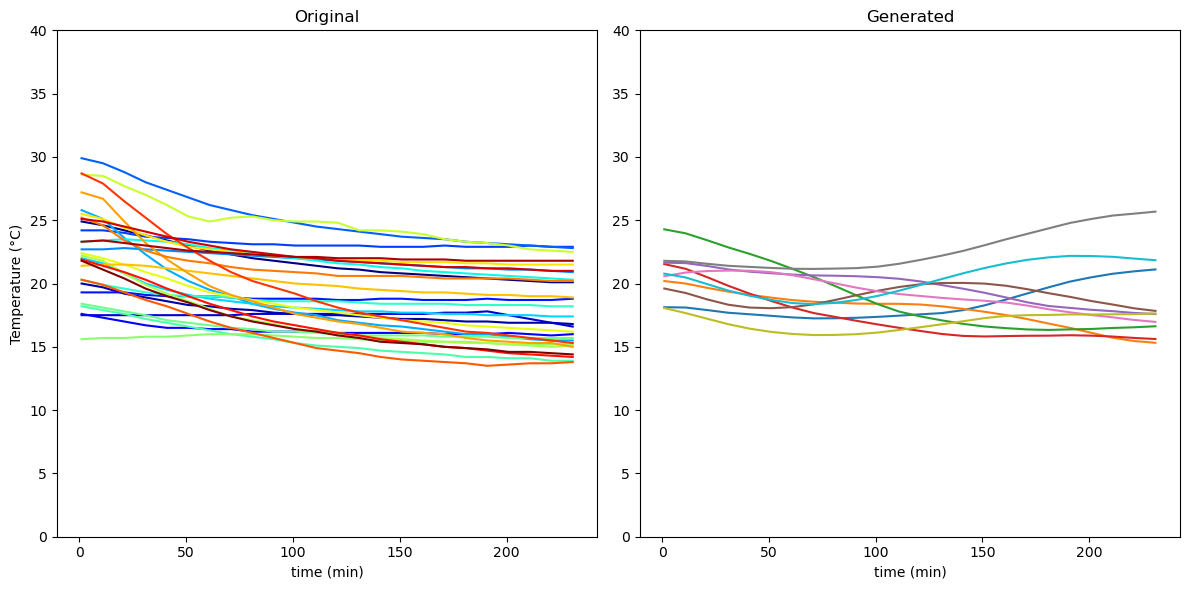

Training Progress:  62%|██████▏   | 167/270 [00:16<00:09, 10.97it/s]

Epoch 169:
  Training - Loss = 0.5399, KL = 0.1876, MSE = 0.7275, CE = 0.0249
  Validation - Loss = 0.6637, KL = 0.1405, MSE = 0.8042, CE = 0.0329
  Mean q_mu = 0.8340, Mean q_var = 0.0503


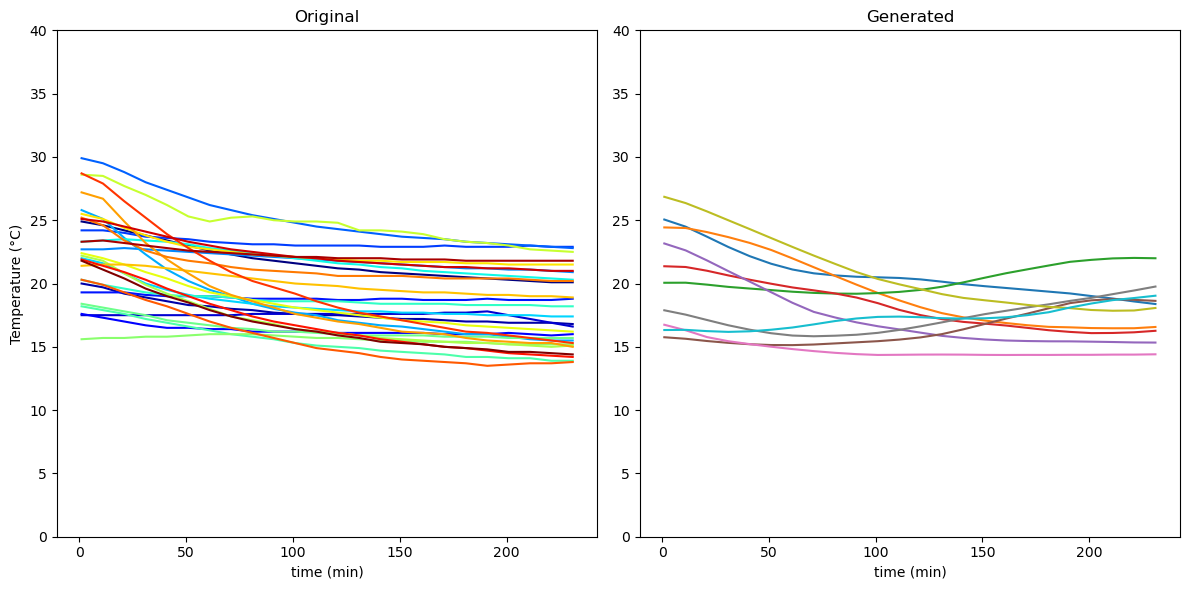

Training Progress:  67%|██████▋   | 180/270 [00:17<00:08, 11.04it/s]

Epoch 182:
  Training - Loss = 0.6278, KL = 0.1823, MSE = 0.8102, CE = 0.0249
  Validation - Loss = 0.8209, KL = 0.1283, MSE = 0.9492, CE = 0.0352
  Mean q_mu = 0.8042, Mean q_var = 0.0501


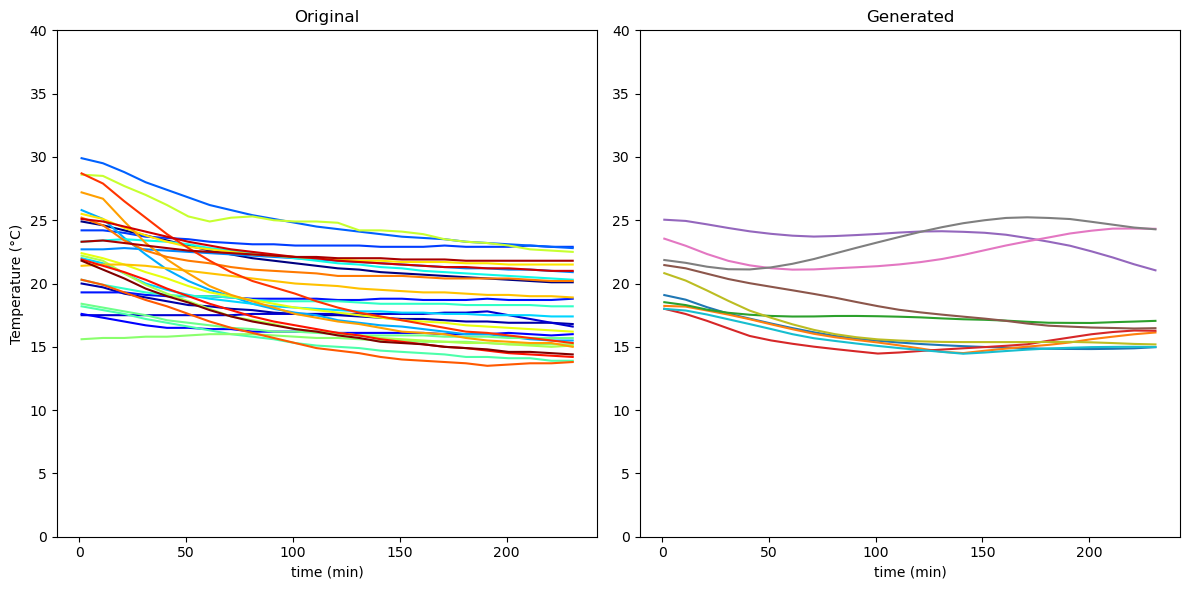

Training Progress:  71%|███████▏  | 193/270 [00:19<00:07, 10.91it/s]

Epoch 195:
  Training - Loss = 0.5967, KL = 0.1721, MSE = 0.7689, CE = 0.0272
  Validation - Loss = 0.6766, KL = 0.1162, MSE = 0.7929, CE = 0.0378
  Mean q_mu = 0.8289, Mean q_var = 0.0502


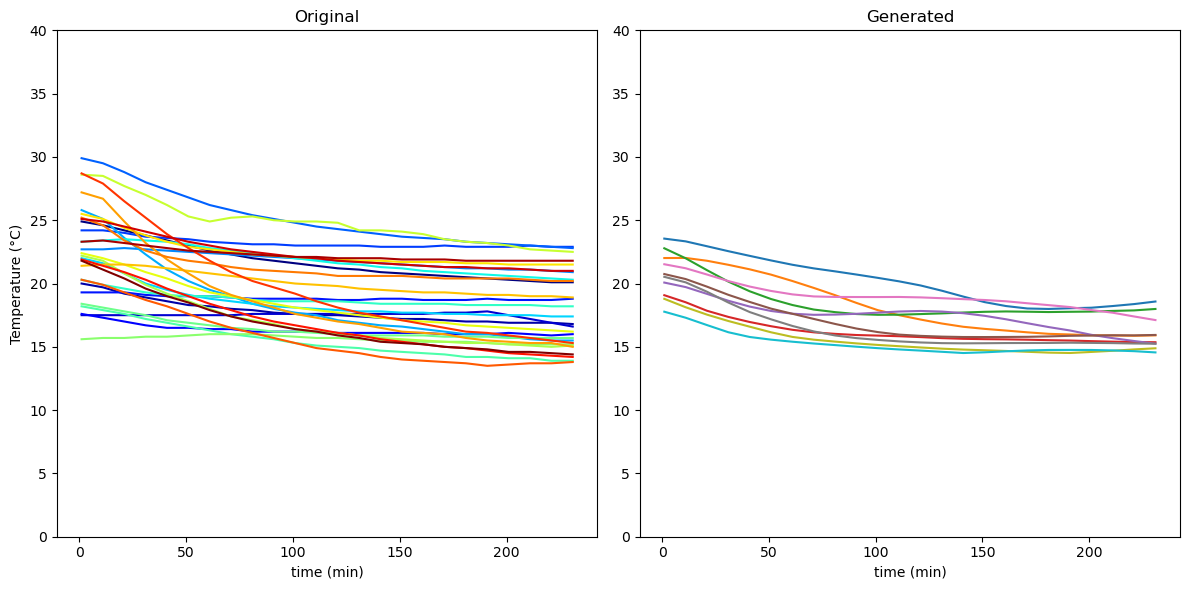

Training Progress:  76%|███████▋  | 206/270 [00:20<00:05, 10.97it/s]

Epoch 208:
  Training - Loss = 0.5455, KL = 0.1645, MSE = 0.7100, CE = 0.0270
  Validation - Loss = 0.6141, KL = 0.1043, MSE = 0.7184, CE = 0.0390
  Mean q_mu = 0.8416, Mean q_var = 0.0500


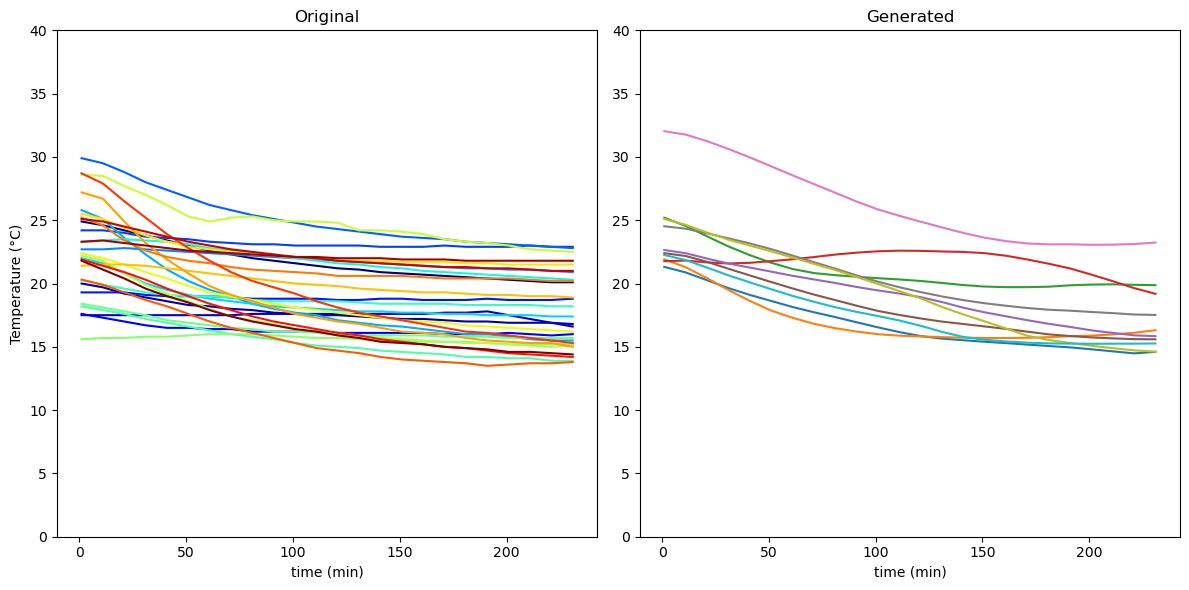

Training Progress:  81%|████████▏ | 220/270 [00:21<00:04, 10.91it/s]

Epoch 221:
  Training - Loss = 0.5536, KL = 0.1527, MSE = 0.7063, CE = 0.0302
  Validation - Loss = 0.7252, KL = 0.0932, MSE = 0.8183, CE = 0.0412
  Mean q_mu = 0.8918, Mean q_var = 0.0501


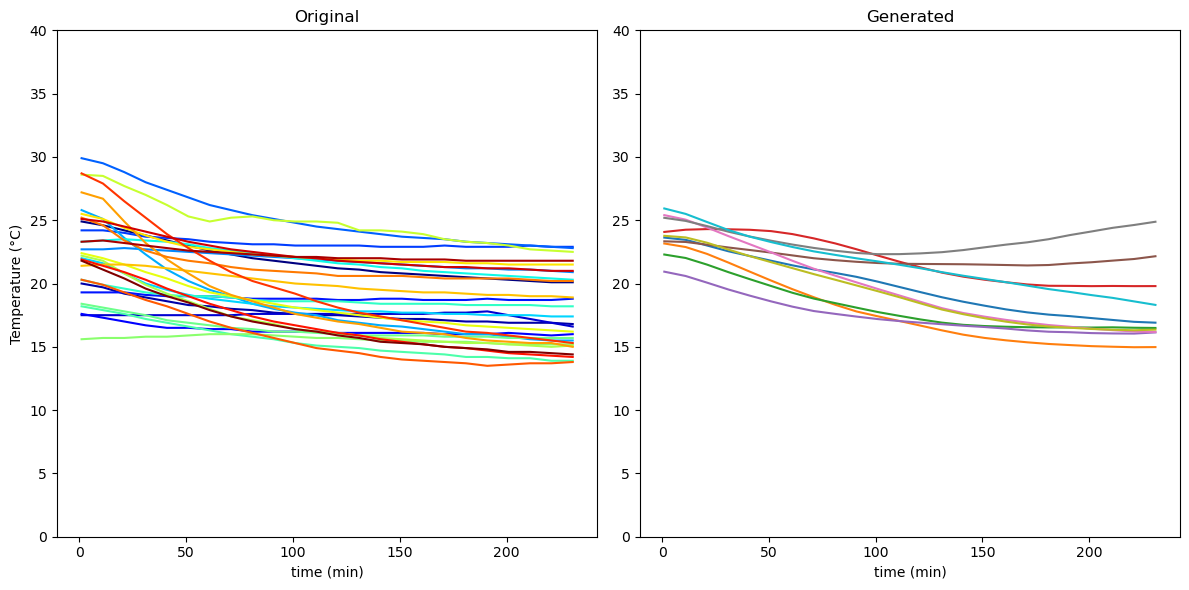

Training Progress:  86%|████████▌ | 232/270 [00:23<00:03, 10.27it/s]

Epoch 234:
  Training - Loss = 0.4996, KL = 0.1457, MSE = 0.6453, CE = 0.0298
  Validation - Loss = 0.6798, KL = 0.0885, MSE = 0.7683, CE = 0.0433
  Mean q_mu = 0.8848, Mean q_var = 0.0499


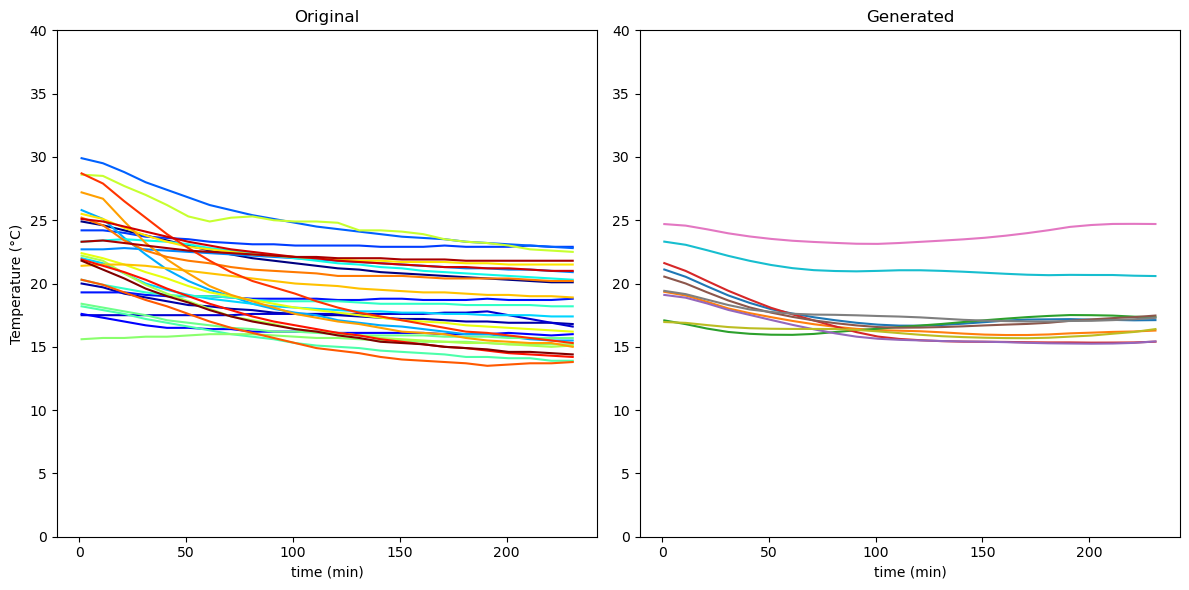

Training Progress:  91%|█████████ | 246/270 [00:24<00:02, 10.82it/s]

Epoch 247:
  Training - Loss = 0.4677, KL = 0.1361, MSE = 0.6039, CE = 0.0321
  Validation - Loss = 0.6549, KL = 0.0698, MSE = 0.7247, CE = 0.0466
  Mean q_mu = 0.9204, Mean q_var = 0.0499


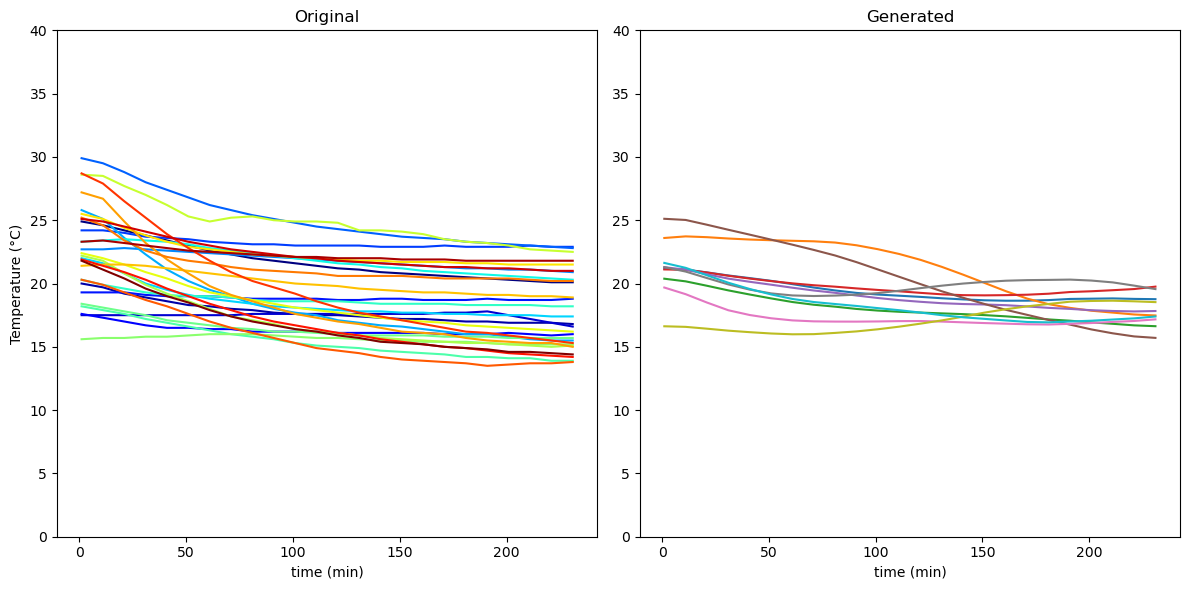

Training Progress:  96%|█████████▌| 259/270 [00:25<00:01, 10.73it/s]

Epoch 260:
  Training - Loss = 0.5476, KL = 0.1298, MSE = 0.6774, CE = 0.0325
  Validation - Loss = 0.7945, KL = 0.0675, MSE = 0.8620, CE = 0.0479
  Mean q_mu = 0.9237, Mean q_var = 0.0498


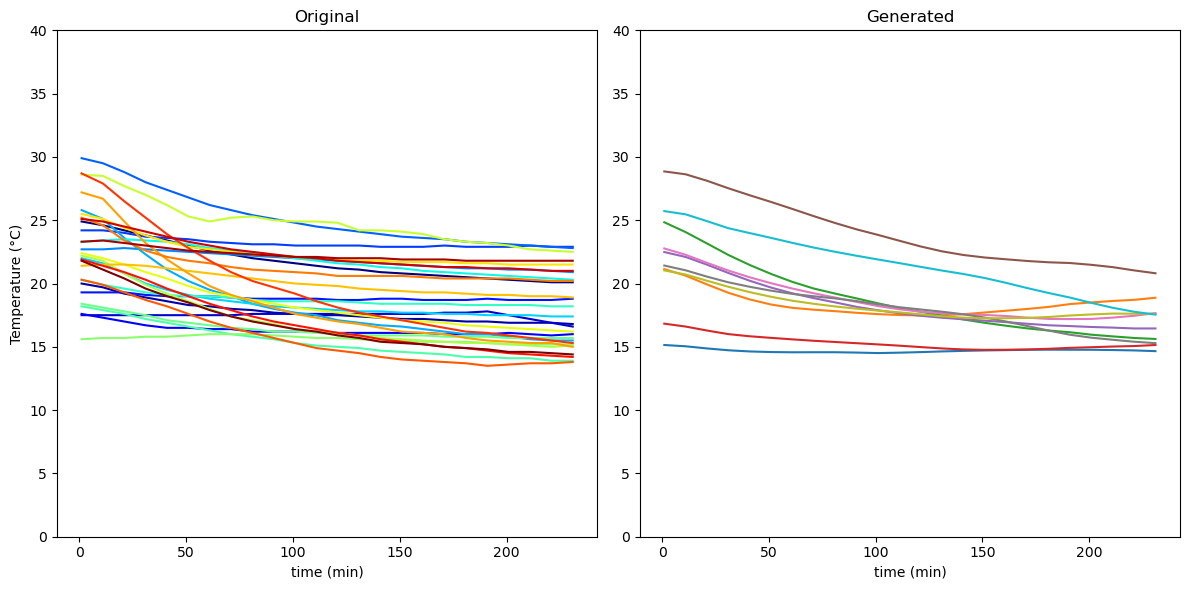

Training Progress:  99%|█████████▉| 268/270 [00:26<00:00, 10.49it/s]

Epoch 270:
  Training - Loss = 0.4474, KL = 0.1222, MSE = 0.5695, CE = 0.0356
  Validation - Loss = 0.5030, KL = 0.0440, MSE = 0.5470, CE = 0.0514
  Mean q_mu = 0.9410, Mean q_var = 0.0499


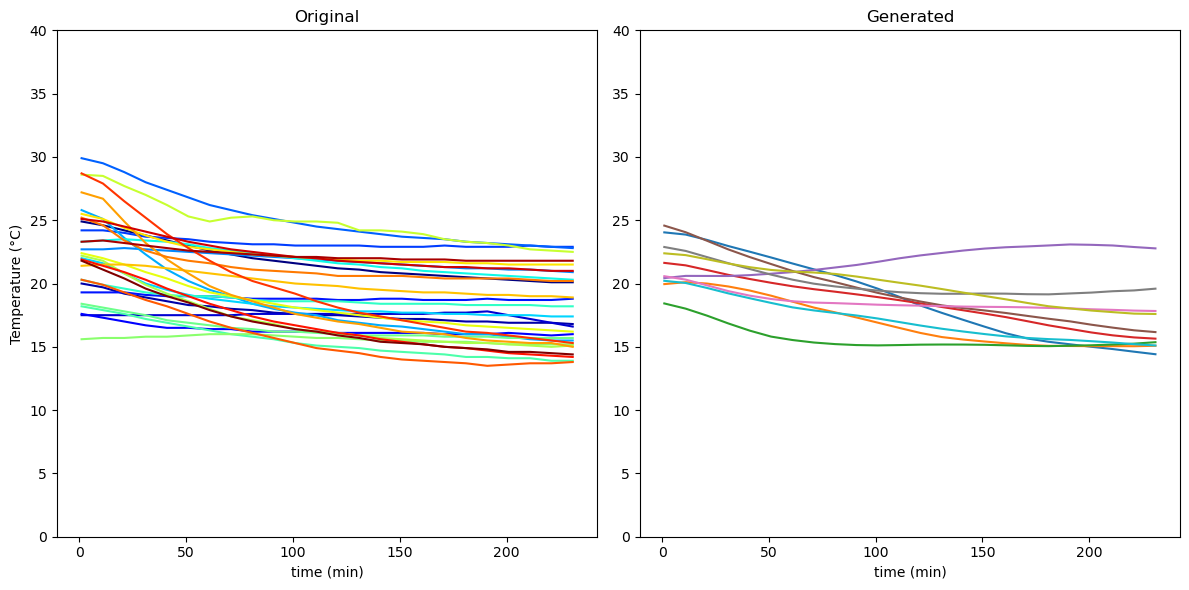

Training Progress: 100%|██████████| 270/270 [00:27<00:00,  9.93it/s]


In [6]:
beta = 1
num_epochs = 270
torch.manual_seed(123)
metrics = model.fit(train_loader, val_loader, 
                    opt, beta, num_epochs, 
                    t_uni=t_uni/240, 
                    num_samples=10, 
                    ylim=(0,40), 
                    df=df_c, 
                    plot=True)

In [ ]:
# torch.save(model.state_dict(), 'pre_trained_models/GPVAE_cooling.pth')